### Gaussian mixture models
- http://scikit-learn.org/stable/modules/mixture.html#gmm

`sklearn.mixture` is a package which enables one to learn Gaussian Mixture Models (diagonal, spherical, tied and full covariance matrices supported), sample them, and estimate them from data. Facilities to help determine the appropriate number of components are also provided.

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. One can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians.

- EM是一种拟合数据的方法
- [a link for EM](https://people.eecs.berkeley.edu/~pabbeel/cs287-fa13/slides/Likelihood_EM_HMM_Kalman.pdf)
- 可以使用`BIC`来评估类的个数

The `GaussianMixture` object implements the expectation-maximization (EM) algorithm for fitting mixture-of-Gaussian models. It can also draw confidence ellipsoids for multivariate models, and compute the `Bayesian Information Criterion` to assess the number of clusters in the data. A `GaussianMixture.fit` method is provided that learns a Gaussian Mixture Model from train data. Given test data, it can assign to each sample the Gaussian it mostly probably belong to using the `GaussianMixture.predict` method.

---
#### 1.1 Example 1 - GMM covariances
- Demonstration of several covariances types for Gaussian mixture models.

Although GMM are often used for clustering, we can compare the obtained clusters with the actual classes from the dataset. We initialize the means of the Gaussians with the means of the classes from the training set to make this comparison valid.

We plot predicted labels on both training and held out test data using a variety of GMM covariance types on the iris dataset. We compare GMMs with spherical, diagonal, full, and tied covariance matrices in increasing order of performance. Although one would expect full covariance to perform best in general, it is prone to overfitting on small datasets and does not generalize well to held out test data. (full covariance容易过拟合)

On the plots, train data is shown as dots, while test data is shown as crosses. The iris dataset is four-dimensional. Only the first two dimensions are shown here, and thus some points are separated in other dimensions.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

In [2]:
print(__doc__)

Automatically created module for IPython interactive environment


In [3]:
colors = ['navy', 'turquoise', 'darkorange']
def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)


In [4]:
iris = datasets.load_iris()

# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(iris.data, iris.target)))
train_index.shape, test_index.shape

((111,), (39,))

In [5]:
X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]

In [6]:
n_classes = len(np.unique(y_train))
n_classes

3

In [7]:
# Try GMMs using different types of covariances.
estimators = dict((cov_type, GaussianMixture(n_components=n_classes,
                   covariance_type=cov_type, max_iter=20, random_state=0))
                  for cov_type in ['spherical', 'diag', 'tied', 'full'])
estimators

{'spherical': GaussianMixture(covariance_type='spherical', init_params='kmeans',
         max_iter=20, means_init=None, n_components=3, n_init=1,
         precisions_init=None, random_state=0, reg_covar=1e-06, tol=0.001,
         verbose=0, verbose_interval=10, warm_start=False,
         weights_init=None),
 'diag': GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=20,
         means_init=None, n_components=3, n_init=1, precisions_init=None,
         random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
         verbose_interval=10, warm_start=False, weights_init=None),
 'tied': GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=20,
         means_init=None, n_components=3, n_init=1, precisions_init=None,
         random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
         verbose_interval=10, warm_start=False, weights_init=None),
 'full': GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=20,
         means_init=None, n

In [8]:
n_estimators = len(estimators)

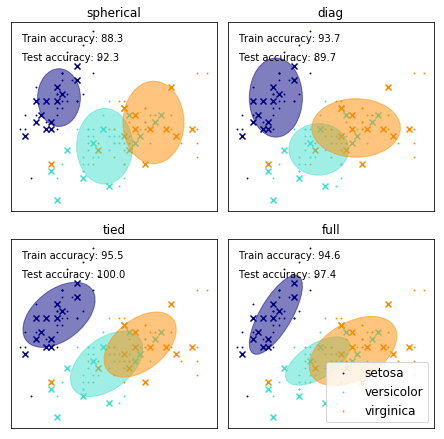

In [9]:
plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05, left=.01, right=.99)

for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    # 直接设置每个cluster的初始位置
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0) for i in range(n_classes)])

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)  # 训练模型

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = iris.data[iris.target == n]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color,
                    label=iris.target_names[n])
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)

    y_train_pred = estimator.predict(X_train)  # 预测training set中的数据
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)  # 预测test set中的数据
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))


---
#### 1.2 Example 2 - Gaussian Mixture Model Selection
- http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#sphx-glr-auto-examples-mixture-plot-gmm-selection-py

The BIC criterion can be used to select the number of components in a Gaussian Mixture in an efficient way. In theory, it recovers the true number of components only in the asymptotic regime (i.e. if much data is available and assuming that the data was actually generated i.i.d. from a mixture of Gaussian distribution). Note that using a Variational Bayesian Gaussian mixture avoids the specification of the number of components for a Gaussian mixture model.

In [84]:
import numpy as np
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

print(__doc__)

Automatically created module for IPython interactive environment


In [85]:
# Number of samples per component
n_samples = 500

# Generate random sample, two components
np.random.seed(0)
C = np.array([[0., -0.1], [1.7, .4]])
X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
          .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]
X.shape

(1000, 2)

In [86]:
lowest_bic = np.infty  # + infinity
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']
lowest_bic, n_components_range

(inf, range(1, 7))

In [87]:
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))  # 每种类型连续6种不同的component
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

In [88]:
bic, len(bic)

([9451.8511167276083,
  6757.3990000918293,
  6788.042385536467,
  6028.0086976468237,
  5762.8354246089248,
  5788.4668011371305,
  8009.3425868309023,
  6226.9590556611993,
  6041.6581602271954,
  5683.8065767982671,
  5563.773010838293,
  5279.8246973115529,
  9000.2537282772864,
  5991.4033228420612,
  6024.7390984027124,
  5342.6632691877994,
  5374.1102901712302,
  5186.5985651036581,
  8009.3425868309023,
  4560.7707096879913,
  4604.7145407139569,
  4639.4358094343334,
  4669.0221454806924,
  4715.8453721322703],
 24)

In [89]:
bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue', 'darkorange'])  # 可以循环使用
clf = best_gmm  # 最优模型
bars = []

In [90]:
color_iter

In [91]:
dict(zip(cv_types, color_iter))

{'spherical': 'navy',
 'tied': 'turquoise',
 'diag': 'cornflowerblue',
 'full': 'darkorange'}

In [92]:
bic.argmin()

19

In [93]:
np.mod(bic.argmin(), len(n_components_range)) + .65 + .2 * np.floor(bic.argmin() / len(n_components_range))

2.25

In [94]:
list(zip(clf.means_, clf.covariances_, color_iter))

[(array([-0.04275113, -0.00352252]), array([[ 2.88961965,  0.68164604],
         [ 0.68164604,  0.17027464]]), 'navy'),
 (array([-5.9846751 ,  3.00373881]), array([[ 0.46415545, -0.00870309],
         [-0.00870309,  0.45436652]]), 'turquoise')]

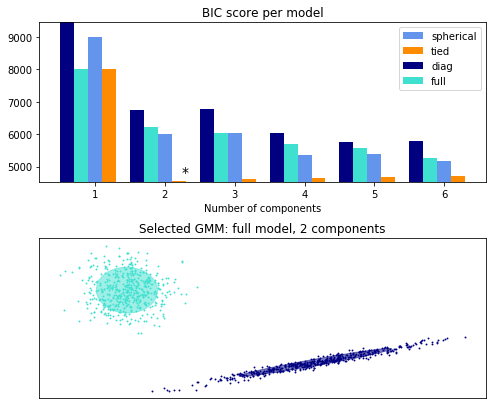

In [102]:
# Plot the BIC scores
plt.figure(figsize=(8, 6))  # 啊哈moment
spl = plt.subplot(2, 1, 1)  #创建画纸
# spl.set_figure(figsize=(8, 6))
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    # 每次取6个值，包含某一类型的全部bic值
    bars.append(plt.bar(xpos, bic[i * len(n_components_range): (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X)  # 利用最优模型对X进行分类
# 最优模型包含两类，因此就有两个mean值，两个协方差矩阵
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)  # 协方差矩阵的特征向量
    if not np.any(Y_ == i):
        continue  # 跳到循环开始
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0]) # 计算角度（弧度）
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)  # width, height
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)  # ???
    ell.set_alpha(.5)  # 设置椭圆的透明度
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title('Selected GMM: full model, 2 components')
plt.subplots_adjust(hspace=.35, bottom=0.01)
# plt.tight_layout()
# plt.savefig('test3.png', dpi=200)

---
#### 1.3 Example 3 - Concentration Prior Type Analysis of Variation Bayesian Gaussian Mixture
- http://scikit-learn.org/stable/auto_examples/mixture/plot_concentration_prior.html#

This example plots the ellipsoids obtained from a toy dataset (mixture of three Gaussians) fitted by the `BayesianGaussianMixture` class models with a Dirichlet distribution prior(狄利克雷分布先验？) (`weight_concentration_prior_type='dirichlet_distribution'`) and a Dirichlet process prior(狄利克雷过程先验？) (`weight_concentration_prior_type='dirichlet_process'`). On each figure, we plot the results for three different values of the weight concentration prior.

The `BayesianGaussianMixture` class can adapt its number of mixture components automatically. The parameter `weight_concentration_prior` has a direct link with the resulting number of components with non-zero weights. Specifying a low value for the concentration prior will make the model put most of the weight on few components set the remaining components weights very close to zero. High values of the concentration prior will allow a larger number of components to be active in the mixture.

The Dirichlet process prior allows to define an infinite number of components and automatically selects the correct number of components: it activates a component only if it is necessary.(狄利克雷过程先验科研将cluster的数量设置成无穷，然后只激活必要的cluster，因此可以做到自动选择cluster的数量)

On the contrary the classical finite mixture model with a Dirichlet distribution prior will favor more uniformly weighted components and therefore tends to divide natural clusters into unnecessary sub-components.(狄利克雷分布相关的有限混合模型倾向于将cluster的权重看成是均匀分布的)

In [48]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.mixture import BayesianGaussianMixture

print(__doc__)

Automatically created module for IPython interactive environment


In [55]:
def plot_ellipses(ax, weights, means, covars):
    for n in range(means.shape[0]):
        eig_vals, eig_vecs = np.linalg.eigh(covars[n])
        unit_eig_vec = eig_vecs[0] / np.linalg.norm(eig_vecs[0])
        angle = np.arctan2(unit_eig_vec[1], unit_eig_vec[0])
        # Ellipse needs degrees
        angle = 180 * angle / np.pi
        # eigenvector normalization
        eig_vals = 2 * np.sqrt(2) * np.sqrt(eig_vals)
        ell = mpl.patches.Ellipse(means[n], eig_vals[0], eig_vals[1],
                                  180 + angle, edgecolor='black')
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(weights[n])
        ell.set_facecolor('#56B4E9')
        ax.add_artist(ell)
        
def plot_results(ax1, ax2, estimator, X, y, title, plot_title=False):
    ax1.set_title(title)
    ax1.scatter(X[:, 0], X[:, 1], s=5, marker='o', color=colors[y], alpha=0.8)
    ax1.set_xlim(-2., 2.)
    ax1.set_ylim(-3., 3.)
    ax1.set_xticks(())
    ax1.set_yticks(())
    plot_ellipses(ax1, estimator.weights_, estimator.means_,
                  estimator.covariances_)

    ax2.get_xaxis().set_tick_params(direction='out')
    ax2.yaxis.grid(True, alpha=0.7)
    for k, w in enumerate(estimator.weights_):
        ax2.bar(k, w, width=0.9, color='#56B4E9', zorder=3,
                align='center', edgecolor='black')
        ax2.text(k, w + 0.007, "%.1f%%" % (w * 100.),
                 horizontalalignment='center')
    ax2.set_xlim(-.6, 2 * n_components - .4)
    ax2.set_ylim(0., 1.1)
    ax2.tick_params(axis='y', which='both', left=False,
                    right=False, labelleft=False)
    ax2.tick_params(axis='x', which='both', top=False)

    if plot_title:
        ax1.set_ylabel('Estimated Mixtures')
        ax2.set_ylabel('Weight of each component')


In [56]:
# Parameters of the dataset
random_state, n_components, n_features = 2, 3, 2
colors = np.array(['#0072B2', '#F0E442', '#D55E00'])

covars = np.array([[[.7, .0], [.0, .1]],
                   [[.5, .0], [.0, .1]],
                   [[.5, .0], [.0, .1]]])
samples = np.array([200, 500, 200])
means = np.array([[.0, -.70],
                  [.0, .0],
                  [.0, .70]])

# mean_precision_prior= 0.8 to minimize the influence of the prior
estimators = [
    ("Finite mixture with a Dirichlet distribution\nprior and "
     r"$\gamma_0=$", BayesianGaussianMixture(
        weight_concentration_prior_type="dirichlet_distribution",
        n_components=2 * n_components, reg_covar=0, init_params='random',
        max_iter=1500, mean_precision_prior=.8,
        random_state=random_state), [0.001, 1, 1000]),
    ("Infinite mixture with a Dirichlet process\n prior and" r"$\gamma_0=$",
     BayesianGaussianMixture(
        weight_concentration_prior_type="dirichlet_process",
        n_components=2 * n_components, reg_covar=0, init_params='random',
        max_iter=1500, mean_precision_prior=.8,
        random_state=random_state), [1, 1000, 100000])]

# Generate data
rng = np.random.RandomState(random_state)
X = np.vstack([
    rng.multivariate_normal(means[j], covars[j], samples[j])
    for j in range(n_components)])
y = np.concatenate([j * np.ones(samples[j], dtype=int)
                    for j in range(n_components)])

In [57]:
X.shape, y.shape

((900, 2), (900,))

In [58]:
X, y

(array([[-0.34868463, -0.71779313],
        [-1.78726988, -0.18130083],
        [-1.50049586, -0.96618389],
        ..., 
        [-0.83642133,  1.03656465],
        [-1.14717061,  0.40664209],
        [ 0.31504379,  0.59756641]]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

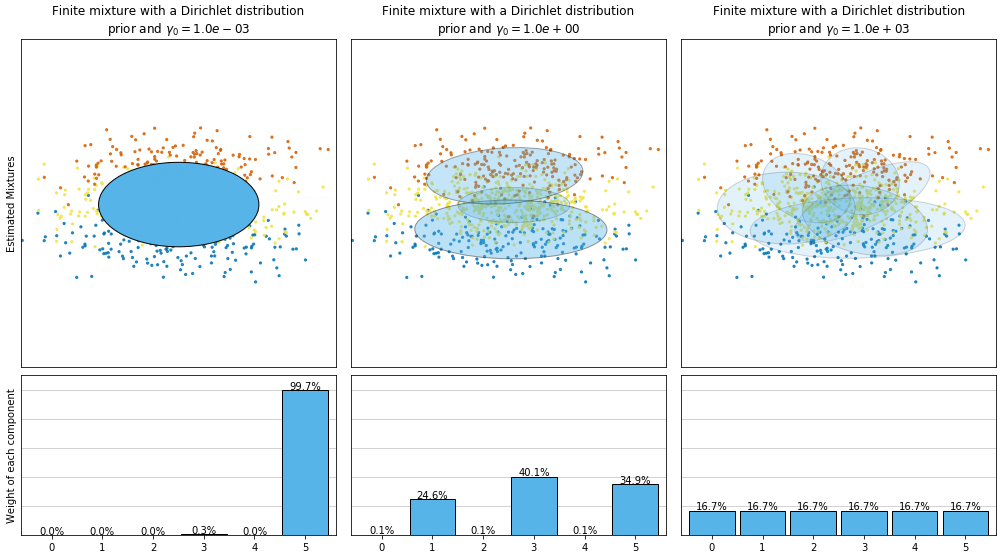

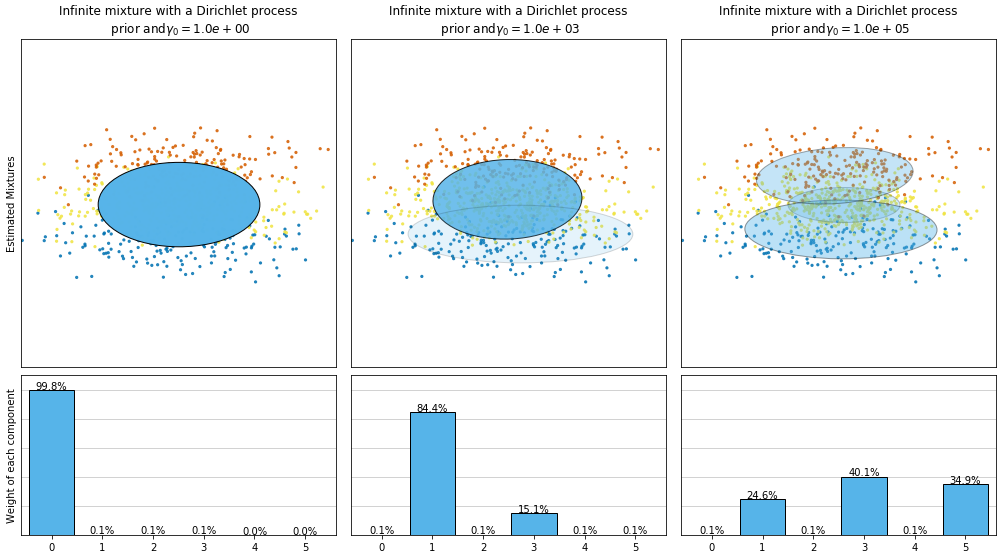

In [59]:
# Plot results in two different figures
for (title, estimator, concentrations_prior) in estimators:
    plt.figure(figsize=(4.7 * 3, 8))
    plt.subplots_adjust(bottom=.04, top=0.90, hspace=.05, wspace=.05,
                        left=.03, right=.99)

    gs = gridspec.GridSpec(3, len(concentrations_prior))
    for k, concentration in enumerate(concentrations_prior):
        estimator.weight_concentration_prior = concentration
        estimator.fit(X)
        plot_results(plt.subplot(gs[0:2, k]), plt.subplot(gs[2, k]), estimator,
                     X, y, r"%s$%.1e$" % (title, concentration),
                     plot_title=k == 0)

---
#### 1.4 Example 4 - Gaussian Mixture Model Sine Curve

This example demonstrates the behavior of Gaussian mixture models fit on data that was not sampled from a mixture of Gaussian random variables. The dataset is formed by 100 points loosely spaced following a noisy sine curve. There is therefore no ground truth value for the number of Gaussian components.

The first model is a classical Gaussian Mixture Model with 10 components fit with the Expectation-Maximization algorithm.(使用EM拟合数据的高斯混合模型，10个compounts)

The second model is a Bayesian Gaussian Mixture Model with a Dirichlet process prior fit with variational inference. The low value of the concentration prior makes the model favor a lower number of active components. This models “decides” to focus its modeling power on the big picture of the structure of the dataset: groups of points with alternating directions modeled by non-diagonal covariance matrices. Those alternating directions roughly capture the alternating nature of the original sine signal.(使用狄利克雷过程先验的贝叶斯高斯混合模型，设置了一个很小的浓度先验值`<concentration prior>`)

The third model is also a Bayesian Gaussian mixture model with a Dirichlet process prior but this time the value of the concentration prior is higher giving the model more liberty to model the fine-grained structure of the data. The result is a mixture with a larger number of active components that is similar to the first model where we arbitrarily decided to fix the number of components to 10.(使用狄利克雷过程先验的贝叶斯高斯混合模型，设置了一个较大的浓度先验值`<concentration prior>`)

Which model is the best is a matter of subjective judgement: do we want to favor models that only capture the big picture to summarize and explain most of the structure of the data while ignoring the details or do we prefer models that closely follow the high density regions of the signal?

The last two panels show how we can sample from the last two models. The resulting samples distributions do not look exactly like the original data distribution. The difference primarily stems from the approximation error we made by using a model that assumes that the data was generated by a finite number of Gaussian components instead of a continuous noisy sine curve.

In [60]:
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

print(__doc__)

Automatically created module for IPython interactive environment


In [78]:
# 这种用法很有意思
color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold', 'darkorange'])

def plot_results(X, Y, means, covariances, index, title):
    splot = plt.subplot(5, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y == i):
            continue  # 有些component没有被激活
        plt.scatter(X[Y == i, 0], X[Y == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-6., 4. * np.pi - 6.)
    plt.ylim(-5., 5.)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())


def plot_samples(X, Y, n_components, index, title):
    plt.subplot(5, 1, 4 + index)
    for i, color in zip(range(n_components), color_iter):
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y == i):
            continue
        plt.scatter(X[Y == i, 0], X[Y == i, 1], .8, color=color)

    plt.xlim(-6., 4. * np.pi - 6.)
    plt.ylim(-5., 5.)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())


In [79]:
# Parameters
n_samples = 100

# Generate random sample following a sine curve
np.random.seed(0)
X = np.zeros((n_samples, 2))
step = 4. * np.pi / n_samples

for i in range(X.shape[0]):
    x = i * step - 6.
    X[i, 0] = x + np.random.normal(0, 0.1)  # 添加随机误差
    X[i, 1] = 3. * (np.sin(x) + np.random.normal(0, .2))


In [81]:
X.shape

(100, 2)

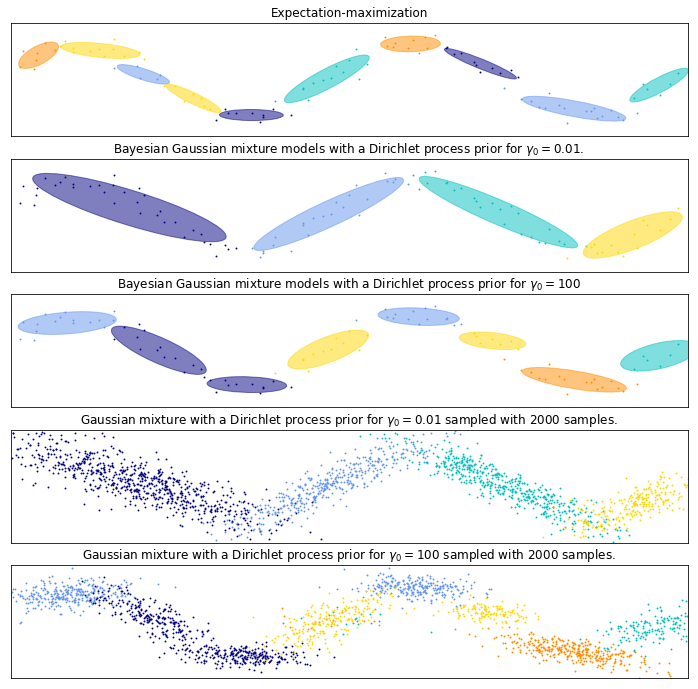

In [82]:
plt.figure(figsize=(10, 10))
plt.subplots_adjust(bottom=.04, top=0.95, hspace=.2, wspace=.05,
                    left=.03, right=.97)

# Fit a Gaussian mixture with EM using ten components
gmm = mixture.GaussianMixture(n_components=10, covariance_type='full',
                              max_iter=100).fit(X)
# 第一个图
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0,
             'Expectation-maximization')

dpgmm = mixture.BayesianGaussianMixture(
    n_components=10, covariance_type='full', weight_concentration_prior=1e-2,
    weight_concentration_prior_type='dirichlet_process',
    mean_precision_prior=1e-2, covariance_prior=1e0 * np.eye(2),
    init_params="random", max_iter=100, random_state=2).fit(X)
# 第二个图
plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 1,
             "Bayesian Gaussian mixture models with a Dirichlet process prior "
             r"for $\gamma_0=0.01$.")

# 从生成模型中抽样
X_s, y_s = dpgmm.sample(n_samples=2000)
# 第四个图
plot_samples(X_s, y_s, dpgmm.n_components, 0,
             "Gaussian mixture with a Dirichlet process prior "
             r"for $\gamma_0=0.01$ sampled with $2000$ samples.")

dpgmm = mixture.BayesianGaussianMixture(
    n_components=10, covariance_type='full', weight_concentration_prior=1e+2,
    weight_concentration_prior_type='dirichlet_process',
    mean_precision_prior=1e-2, covariance_prior=1e0 * np.eye(2),
    init_params="kmeans", max_iter=100, random_state=2).fit(X)
# 第三个图
plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 2,
             "Bayesian Gaussian mixture models with a Dirichlet process prior "
             r"for $\gamma_0=100$")

X_s, y_s = dpgmm.sample(n_samples=2000)
# 第五个图
plot_samples(X_s, y_s, dpgmm.n_components, 1,
             "Gaussian mixture with a Dirichlet process prior "
             r"for $\gamma_0=100$ sampled with $2000$ samples.")